In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import sys
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm

In [2]:
def f(A, b, x):
    return x.T @ A @ x / 2 + x.T @ b

In [3]:
def solution(A, b):
    return - la.inv(A) @ b

In [4]:
def grad_f(a, b, D, i, x):
#     print(i)
    return (np.outer(a[i], a[i]) + D[i]) @ x + b

In [27]:
def grad_f_i(a, b, D, x, random_ind):
#            A, y, x, lambd, random_ind, batch_size=1):
#     print(random_ind, len(random_ind))
    if len(np.array(random_ind, dtype=int)) == 1:
        return np.array(grad_f(a, b, D, *random_ind, x))
    else:
#         grad = np.array([])
#         grad += 
        grad = sum([grad_f(a, b, D, i, x) for i in list(random_ind)]) / len(random_ind)
    #     grad = np.dot(A[random_ind].T, (np.dot(A[random_ind], x) - y[random_ind])) + batch_size*lambd * x
    #     grad = grad/batch_size
        return np.array(grad)

In [7]:
def construct_v_independent_sampling(probab):
    n = len(probab)
    v = []
    for i in range(0, n):
        rand = np.random.rand();
        if rand <= probab[i]:
            v.append(i)
    return v


def construct_tau_nice(n, tau):
    random_sample = np.random.choice(np.arange(n), tau, replace=False)
    return random_sample

In [8]:
# def sgd(A, y, x0, x_star, lambd, probab, step_size, 
#         epsilon=1e-6, max_epoch=100, seed=42, kind="proper", tau = 1):

def sgd(a, b, D, x0, x_star, 
        probab, step_size=1e-2, 
        epsilon=1e-4, max_epoch=100, seed=42, 
        kind="proper", tau=1):    

    np.random.seed(seed)
    
    n = len(D)
    d = len(x0)
    
    x = x0
    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n
    
    epoch_num = 0
    iter_num = 0
    
    n_batch = np.arange(n)
    
    error = [la.norm(x - x_star)**2]
    f_values = [] #[f(A, b, x)]
    
    while epoch_num < max_epoch and error[-1] > epsilon:     
        if (kind == "proper"):
            v = np.random.choice(n_batch, size=n, replace=True, p=probab)
            for i in range(n):
                rand_ind = v[i]
                x = x - step_size * grad_f_i(a, b, D, x, [rand_ind])
                iter_num += 1
        elif (kind == "taunice"):
            v = construct_tau_nice(n, tau)
            x_new = x - step_size * grad_f_i(a, b, D, x, v)
            x = x_new
            iter_num += len(v)
        else:
            v = construct_v_independent_sampling(probab)
            if len(v) == 0:
                x = x
            else:
                x = x - step_size * grad_f_i(a, b, D, x, v)
            iter_num += len(v)

        
        if iter_num >= n :
            file = open("log.txt", "w+")
            file.write(str(epoch_num) + " error: " + str(error[-1]))
            file.close()
            
            epoch_num += 1
            iter_num = 0
            temp = f(A, b, x)
            f_values.append(temp)
            error.append(la.norm(x - x_star)**2)
    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

### Calculating constants

In [9]:
def calculate_h(a, b, D, x_star):
    n = len(D)
    return [la.norm(grad_f(a, b, D, i, x_star))**2 for i in range(n)]

In [10]:
def calculate_sigma_and_L_curly(M, h):
    n = len(M)
    sigma_2 = np.mean(h) #sum([la.norm(grad_f(a, b, D, i, x_star))**2 for i in range(n)]) / n
    L_curly = max([max(abs(la.eigvals(M[i]))) for i in range(n)])

    return sigma_2, L_curly

In [11]:
def calculate_M(a, D):
    n = len(D)
    return [np.outer(a[i], a[i]) + D[i] for i in range(n)]

$$
h_i = \| \nabla f_i(x^*) \|^2
$$

For proper & non-vacuous sampling
$$
\sigma^2 = \frac{1}{n^2} \sum_{i \in [n]} \frac{1}{p_i} h_i
$$
$$
\mathcal{L} = \frac{1}{n} \max_{i \in [n]} \frac{\lambda_{\max} (M_i)}{p_i}
$$

In [12]:
def calculate_sigma2_proper (probab, h):
    n = len(probab)
    sig = 0
    for i in range(n):
        sig += (1 / probab[i]) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_proper (probab, M):
    n = len(probab)
    L = max([max(abs(la.eigvals(M[i])))/probab[i] for i in range(n)])
    L = L/n
    
    return L

For independent sampling where $\mathbb{E}(|S|) = \tau$
$$
\sigma^2 = \frac{1}{n^2} \sum_{i \in [n]} (\frac{1}{p_i}-1)  h_i   \\
\mathcal{L} := \mathcal{L}^i_{\text{max}} = \sum_{j \in [n]} \frac{\lambda_{\max}(M_j)}{n} + \max_{i \in [n]} (\frac{1}{p_i} - 1) \frac{\lambda_{max}(M_i)}{n} \\
$$

In [13]:
def calculate_sigma2_indepedent (probab, h):
    n = len(probab)
    sig = 0

    for i in range(n):
        sig += (1 / probab[i] - 1) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_indepedent (probab, M):
    L = 0
    n = len(probab)
    
    for i in range(n):
        L += max(abs(la.eigvals(M[i])))/n
    
    second_term = max([(1 / probab[i] - 1) * max(abs(la.eigvals(M[i])))/n for i in range(n)])
    L += second_term
    
    return L

For $\tau$-nice sampling, we have:
$$
\sigma^2 = \frac{1}{n \tau} \frac{n-\tau}{n-1} \sum_{i \in [n]} h_i
$$
$$
\mathcal{L} = \frac{1}{\tau} \frac{\tau-1}{n-1} \sum_{j \in [n]} \lambda_{\max} (M_j) + \frac{1}{\tau}(1-\frac{\tau-1}{n-1}) \max_{i \in [n]} \lambda_{\max} (M_i)
$$

In [14]:
def calculate_sigma2_taunice (h, tau):
    n = len(h)
    sig = 0

    for i in range(n):
        sig += h[i]
    sig = sig/(n*tau)*(n-tau)/(n-1)
    
    return sig

def calculate_L_cal_taunice (M, tau, n):
    L = 0

    for i in range(n):
        L += max(abs(la.eigvals(M[i])))/n
        
    L = L/tau*(tau-1)/(n-1)
    
    second_term = max([max(abs(la.eigvals(M[i]))) for i in range(n)])
    second_term = second_term/tau*(1-(tau-1)/(n-1))
    L += second_term
    
    return L

$$
p_i^{\mathcal{L}} = \frac{\lambda_{\max}(M_i)}{\sum_{j \in [n]} \lambda_{\max} (M_j)} \tau
$$

In [15]:
def calculate_prob_L(M, n, tau):
    pl = np.zeros(n)
    s = sum([max(abs(la.eigvals(M[i]))) for i in range(n)])
    over = set()
    below = set(range(n))

    for i in range(n):
        pl[i] = max(abs(la.eigvals(M[i]))) / s * tau
        if pl[i] == 1.0:
            below.discard(i)
        if pl[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = pl[ind] - 1
        length_of_rem = len(below)
        pl[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            pl[below_ind] += rem / length_of_rem
            if (pl[below_ind] > 1.0000000001):
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return pl

$$
p^{\sigma^2}_{i} = \frac{\sqrt{h_i}}{\sum_{j \in [n]} \sqrt{h_j}} \tau
$$

In [16]:
def calculate_prob_sigma(h, n, tau):
    ps = np.zeros(n)
    s = sum([abs(np.sqrt(h[i])) for i in range(n)])
    over = set()
    below = set(range(n))
    
    for i in range(n):
        ps[i] = np.sqrt(h[i]) / s * tau
        if ps[i] == 1.0:
            below.discard(i)
        if ps[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = ps[ind] - 1
        length_of_rem = len(below)
        ps[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            ps[below_ind]+= rem / length_of_rem
            if ps[below_ind] > 1.0000000001:
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return ps

In [17]:
def calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu):
    a = 2 * (sum([np.sqrt(h[i]) for i in range(n)])/n)**2 / (epsilon * mu * sum([max(abs(la.eigvals(M[i]))) for i in range(n)])/n)
#     print(a)
    alpha = (tau - a - 1 + np.sqrt(4 * tau + (tau - a - 1)**2)) / (2 * tau)
    
    pl = calculate_prob_L(M, n, int(alpha*tau))
    ps = calculate_prob_sigma(h, n, int((1-alpha)*tau))
    
#     print(alpha)
    p_opt =  pl +  ps
    
    return p_opt

In [18]:
def calculate_optimal_prob_proper(M, h, n, epsilon, mu):
    pl = calculate_prob_L(M, n, 1)
    ps = calculate_prob_sigma(h, n, 1)
    L_opt = sum([max(abs(la.eigvals(M[i]))) for i in range(n)])/n
    sig2_opt = (sum([abs(np.sqrt(h[i])) for i in range(n)])/n)**2
    print(sig2_opt)
    alpha = epsilon*mu*L_opt/(2*sig2_opt+epsilon*mu*L_opt)
    print(alpha)
    p_opt = alpha * pl + (1 - alpha) * ps
    
    return p_opt

In [19]:
def calculate_stepsize(L_cal, epsilon, mu, sigma2):
    gamma = min(1 / (2 * L_cal), epsilon * mu / (4 * sigma2))

    return gamma

In [20]:
def calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n):
    k = max(2 * L_cal / mu, 4 * sigma2 / (epsilon * mu**2)) * np.log(2 * la.norm(x0 - x_star)**2 / epsilon)
    return k/n

In [21]:
def calculate_tau_star_independent(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    t = n*(2/(mu*epsilon)*h_bar - L_max)/(2/(mu*epsilon)*h_bar - L_max + sum(L))
    return t
    

In [22]:
def calculate_tau_star_taunice(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    L_bar = sum(L)/n
    
    t = n*(L_bar - L_max + 2/(mu*epsilon)*h_bar)/(n*L_bar - L_max + 2/(mu*epsilon)*h_bar)
    return t
    

## Data

In [99]:
a[0].shape

(10,)

In [36]:
n, d = 1000, 10
scale = 10
epsilon = 1e-3
max_epoch = 5000
tau = int(n/10)

np.random.seed(0)

a = np.random.rand(n, d) * scale
# a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
# Matrix normalization for ||a||_2 = 1
# a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.rand(d) * scale
#np.random.normal(scale=scale, size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))


# Analytical solution
x_star = solution(A, b)

# Problem constants
mu = min(la.eigvals(A))
print("Mu =", mu)

# Decomposition
delta = scale + 1
D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

L = [max(abs(la.eigvals(M[i]))) for i in range(n)]

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

# step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

x0 = np.random.normal(size=len(x_star))
print("Expected minimum number of steps for epsilon-accuracy:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x0)**2 / epsilon))

Mu = 7.17397645903224
Sigma_2 = 4182.774758900282 
L_curly = 640.4665828307931 

Step size: 0.0007806808558067995
Expected minimum number of steps for epsilon-accuracy: 3384923.906041582


In [37]:
print(n, d)

1000 10


## Proper, non-vacuous sampling

In [38]:
probab_uniform = np.ones(n)/n
L_cal = calculate_L_cal_proper(probab_uniform, M)
sigma2 = calculate_sigma2_proper(probab_uniform, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 3384.9239060415803
Stepsize: 4.287809452186708e-07


In [39]:
x_opt_proper, f_val_proper, x_err_proper = sgd(a, b, D, x0, x_star, 
                                               probab=probab_uniform, step_size=step_size, 
                                               epsilon=epsilon, max_epoch=max_epoch, 
                                               kind="proper", tau=1) 
#sgd(A, y, x_0, x_star, lambd, probab_uniform, step_size, epsilon=epsilon, max_epoch=epoch_num, kind="proper")

Number of epochs: 1434
Error: 0.0009984040784083333



#### Proper, non-vacuous sampling, Importance

In [41]:
p_proper_opt = calculate_optimal_prob_proper(M, h, n, epsilon, mu)
L_cal = calculate_L_cal_proper(p_proper_opt, M)
sigma2 = calculate_sigma2_proper(p_proper_opt, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

2911.5442257437076
0.00040726723395073964
Expected number of epochs: 2356.1767318278226
Stepsize: 6.159940603436213e-07


In [42]:
# x_opt_proper_importance, f_val_proper_importance, x_err_proper_importance = sgd(A, y, x0, x_star, lambd, 
#                                 p_proper_opt, step_size, epsilon=epsilon, max_epoch=epoch_num, kind="proper")

## Independence Sampling

In [43]:
p_uniform = np.ones(n)/n*tau
L_cal = calculate_L_cal_indepedent(p_uniform, M)
sigma2 = calculate_sigma2_indepedent(p_uniform, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 30.46431515437425
Stepsize: 4.764232724651894e-05


In [44]:
x_opt_indep, f_val_indep, x_err_indep = sgd(a, b, D, x0, x_star, 
                                               probab=p_uniform, step_size=step_size, 
                                               epsilon=epsilon, max_epoch=max_epoch, 
                                               kind="independent", tau=1) 
# sgd(A, y, x0, x_star, lambd, p_uniform, step_size,
#                              epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 1247
Error: 0.0009952087309089345



#### Independence, importance

In [45]:
p_optimal = calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu)
L_cal = calculate_L_cal_indepedent(p_optimal, M)
sigma2 = calculate_sigma2_indepedent(p_optimal, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 20.414838868745562
Stepsize: 7.109489725867076e-05


In [46]:
# x_opt_indep_importance, f_val_indep_importance, x_err_indep_importance = sgd(A, y, x0, x_star, lambd, p_optimal, step_size,
#                              epsilon=epsilon, max_epoch=epoch_num, kind="independent")

#### Independent, uniform with optimal minibatch

In [47]:
tau_star = calculate_tau_star_independent(h, L, n, mu, epsilon)
tau_star = int(tau_star)
p_uniform_tau = np.ones(n)/n*tau_star
L_cal = calculate_L_cal_indepedent(p_uniform_tau, M)
sigma2 = calculate_sigma2_indepedent(p_uniform_tau, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 0.9658780297445133
Stepsize: 0.00150266475396453


In [48]:
x_opt_indep_tau, f_val_indep_tau, x_err_indep_tau = sgd(a, b, D, x0, x_star, 
                                               probab=p_uniform_tau, step_size=step_size, 
                                               epsilon=epsilon, max_epoch=max_epoch, 
                                               kind="independent") 
# sgd(A, y, x0, x_star, lambd, p_uniform_tau, step_size,
#                              epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 209
Error: 0.000942608855770687



#### $\tau$-nice sampling

In [49]:
p_uniform_tau = np.ones(n)/n*tau
L_cal = calculate_L_cal_taunice(M, tau, n)
sigma2 = calculate_sigma2_taunice(h, tau)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 30.494809964338582
Stepsize: 4.7594684919272426e-05


In [50]:
x_opt_taunice, f_val_taunice, x_err_taunice = sgd(a, b, D, x0, x_star, 
                                               probab=p_uniform_tau, step_size=step_size, 
                                               epsilon=epsilon, max_epoch=max_epoch, 
                                               kind="taunice", tau=tau) 

Number of epochs: 1270
Error: 0.0009940533750402581



#### $\tau$-nice with optimal $\tau$

In [51]:
taunice_opt = int(calculate_tau_star_taunice(h, L, n, mu, epsilon))
print(taunice_opt)
# taunice_opt = n
L_cal = calculate_L_cal_taunice(M, taunice_opt, n)
sigma2 = calculate_sigma2_taunice(h, taunice_opt)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

779
Expected number of epochs: 0.9612541723176189
Stepsize: 0.0015098929229367378


In [52]:
x_opt_taunice_taustar, f_val_taunice_taustar, x_err_taunice_taustar = sgd(a, b, D, x0, x_star, 
                                                                          probab=np.ones(n)/n, step_size=step_size, 
                                                                          epsilon=epsilon, max_epoch=max_epoch, 
                                                                          kind="taunice", tau=taunice_opt) 
# sgd(A, y, x0, x_star, lambd, np.ones(n)/n, step_size,
#                              epsilon=epsilon, max_epoch=epoch_num, kind="taunice", tau=taunice_opt)

Number of epochs: 199
Error: 0.000992853353621596



In [53]:
from matplotlib.pyplot import figure

In [56]:
import pickle

In [57]:
with open('PCA_synthetic_samplings.pickle'.format(n, d, scale), 'wb') as f:
    pickle.dump([x_err_proper / la.norm(x0 - x_star)**2,
                 x_err_indep / la.norm(x0 - x_star)**2,
                 x_err_indep_tau / la.norm(x0 - x_star)**2,
                 x_err_taunice / la.norm(x0 - x_star)**2,
                 x_err_taunice_taustar / la.norm(x0 - x_star)**2], f)

# # # scalings = {}
# with open('PCA_synthetic_samplings.pickle', 'rb') as f:
#     [[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled]] = pickle.load(f)

In [142]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 30#24
plt.rcParams['ytick.labelsize'] = 30#24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24
plt.rc('text', usetex=True)

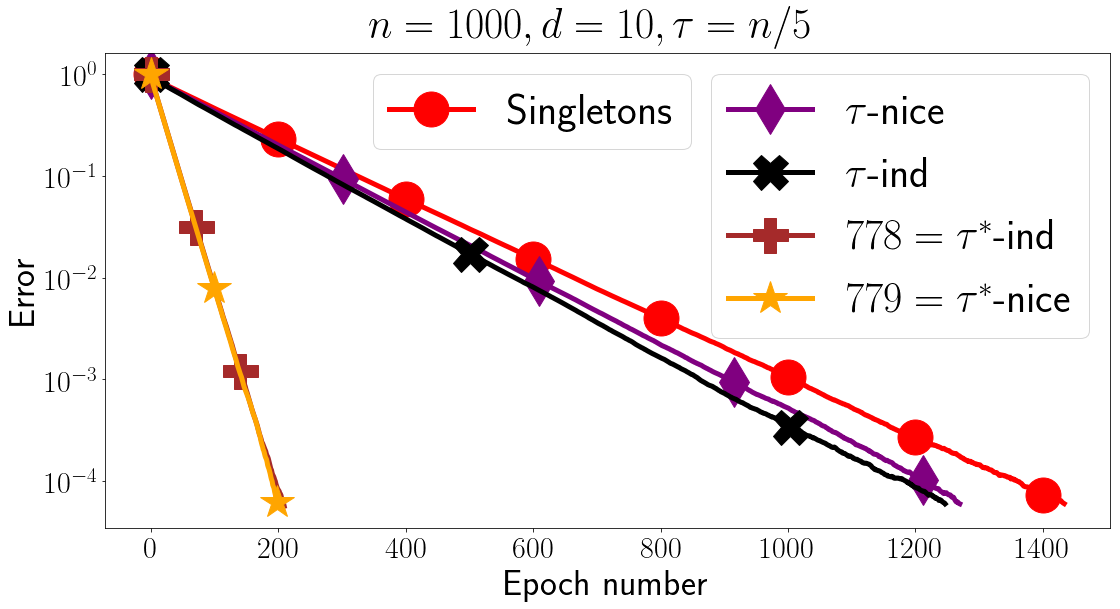

In [187]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
st = fig.suptitle(r"$n = {}, d = {}, \tau=n/5$".format(n, d), fontsize=42)


# plt.semilogy(x_err_proper, label='Constant step size', 
#              marker='o', markersize=35, markevery=10, linewidth=5)

# plt.semilogy(x_err_adapt_scaled, label='Decreasing step size', 
#              marker='D', markersize=35, markevery=10, linewidth=5)

line1, = plt.semilogy(x_err_proper / la.norm(x0 - x_star)**2, color = 'r',
             marker='o',markersize=35, markevery=200, linewidth=5,
             label="Singletons")#r"single element sampling uniform")

line4, = plt.semilogy(x_err_taunice / la.norm(x0 - x_star)**2, color = 'purple', 
             marker='d', markersize=35, markevery=0.198, linewidth=5,
             label=r"$\tau$-nice ")

line2, = plt.semilogy(x_err_indep / la.norm(x0 - x_star)**2, color = 'black', 
             marker='X',markersize=35,  markevery=0.33, linewidth=5,
             label=r"$\tau$-ind")

line3, = plt.semilogy(x_err_indep_tau / la.norm(x0 - x_star)**2, color = 'brown', 
             marker='P', markersize=35, markevery=70, linewidth=5,
             label=r"${}=\tau^*$-ind".format(tau_star))

line5, = plt.semilogy(x_err_taunice_taustar / la.norm(x0 - x_star)**2, color = 'orange', 
             marker='*', markersize=35, markevery=99, linewidth=5,
             label=r"${}=\tau^*$-nice".format(taunice_opt)) #, $\tau^*$ = %d 


plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((None, 400))
# plt.grid()
plt.minorticks_off()
# plt.legend(loc='best', shadow=True, fontsize=42)#, ncol=2) # 
first_legend = plt.legend(handles=[line4, line2, line3, line5], fontsize=42)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line1], fontsize=42, bbox_to_anchor=(0.245, 1))
# (lines, labels) = plt.gca().get_legend_handles_labels()
# leg1 = plt.legend(lines[:1], labels[:1], bbox_to_anchor=(0,0,0.8,1), loc=1)
# leg2 = plt.legend(lines[1:], labels[1:], bbox_to_anchor=(0,0,1,1), loc=1)
# gca().add_artist(leg1)
# gca().add_artist(leg2)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_samplings-comparison_u.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [ ]:
t = np.arange(2, n-1, 2)
st_s = []
for t_bat in t:
    L_cal = calculate_L_cal_taunice(M, t_bat, n)
    sigma2 = calculate_sigma2_taunice(h, t_bat)
    step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
    st_s.append(step_size)

In [ ]:
plt.plot(t, st_s, '+')


plt.grid()
plt.title("Evolution of stepsizes in minibatch size \n n = %d, d = %d, $\lambda = 1/n$, $\epsilon=10^{-3}$" %(n,d))
plt.xlabel(r"minibatch size, $\tau$")
plt.ylabel(r"stepsize, $\gamma$")
plt.savefig("n%d_d%d_stepsize_minibatch.pdf" %(n,d))


plt.show()


## Real Data